Doesn't seem to work very well as the documents are too short.

In [88]:
import pandas as pd
import re
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/oskardale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oskardale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
df0 = pd.read_csv('../0_data/statements.csv')
df1 = pd.read_csv('../0_data/eu_debate_transcripts_translated.csv')

In [86]:
df_chatgpt = df0[df0.provider == 'chatgpt']
df_deepseek = df0[df0.provider == 'deepseek']
documents_chatgpt = df_chatgpt.statement.values.tolist()
documents_deepseek = df_deepseek.statement.values.tolist()
documents_parliament = df1.translated_text.values.tolist()

In [97]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(documents):
    texts = []
    for doc in documents:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc)
        tokens = word_tokenize(doc.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens
                 if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
        texts.append(tokens)

    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    texts = [bigram_mod[doc] for doc in texts]

    return texts

In [98]:
texts = {
    'chatgpt': preprocess_text(documents_chatgpt),
    'deepseek': preprocess_text(documents_deepseek),
    'parliament': preprocess_text(documents_parliament)
}


In [99]:
def train_lda(texts, num_topics=4, passes=15, alpha='auto', beta='auto'):
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=passes,
                         alpha=alpha,
                         eta=beta)
    return {
        'model': lda_model,
        'dict': dictionary,
        'corpus': corpus
    }

In [100]:
def compute_coherence_values(texts, dictionary, corpus, start=2, end=8, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, end, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=42,
                        passes=15,
                        alpha='auto',
                        eta='auto')
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,
                                       texts=texts,
                                       dictionary=dictionary,
                                       coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [101]:
models = {}
for name, text in texts.items():
    print(f"\nFinding optimal number of topics for {name}...")
    dictionary = corpora.Dictionary(text)
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in text]

    model_list, coherence_values = compute_coherence_values(text, dictionary, corpus)
    optimal_num_topics = range(2, 8)[coherence_values.index(max(coherence_values))]
    print(f"Optimal number of topics for {name}: {optimal_num_topics}")

    models[name] = train_lda(text, num_topics=optimal_num_topics)


Finding optimal number of topics for chatgpt...
Optimal number of topics for chatgpt: 4

Finding optimal number of topics for deepseek...
Optimal number of topics for deepseek: 3

Finding optimal number of topics for parliament...
Optimal number of topics for parliament: 5


In [103]:
for name in ['parliament', 'chatgpt', 'deepseek']:
    print(f"\nModel: {name}")
    for idx, topic in models[name]['model'].print_topics(-1):
        print(f"Topic {idx}: {topic}")


Model: parliament
Topic 0: 0.011*"need" + 0.010*"would" + 0.007*"time" + 0.007*"united_state" + 0.007*"partner" + 0.006*"agreement" + 0.006*"negotiation" + 0.006*"economic" + 0.006*"commissioner" + 0.005*"market"
Topic 1: 0.015*"europe" + 0.011*"let" + 0.009*"need" + 0.008*"power" + 0.008*"agreement" + 0.007*"make" + 0.007*"free" + 0.007*"war" + 0.007*"world" + 0.007*"united_state"
Topic 2: 0.011*"market" + 0.009*"policy" + 0.009*"world" + 0.009*"union" + 0.008*"threat" + 0.007*"international" + 0.007*"one" + 0.007*"blackmail" + 0.006*"let" + 0.006*"like"
Topic 3: 0.013*"united_state" + 0.011*"world" + 0.011*"europe" + 0.010*"one" + 0.009*"commissioner" + 0.009*"face" + 0.009*"political" + 0.008*"order" + 0.008*"economy" + 0.008*"union"
Topic 4: 0.019*"europe" + 0.013*"union" + 0.010*"war" + 0.010*"economy" + 0.009*"need" + 0.008*"economic" + 0.007*"united_state" + 0.006*"commissioner" + 0.006*"market" + 0.006*"world"

Model: chatgpt
Topic 0: 0.016*"let" + 0.013*"gentleman" + 0.013*"l

In [104]:
from gensim.models import CoherenceModel
for name, text in texts.items():
    coherence_model_lda = CoherenceModel(model=models[name]['model'],
                                         texts=text,
                                         dictionary=models[name]['dict'],
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Coherence Score for {name}: ', coherence_lda)

Coherence Score for chatgpt:  0.2675982817985043
Coherence Score for deepseek:  0.3427634634642267
Coherence Score for parliament:  0.35421534541065675



Model: parliament


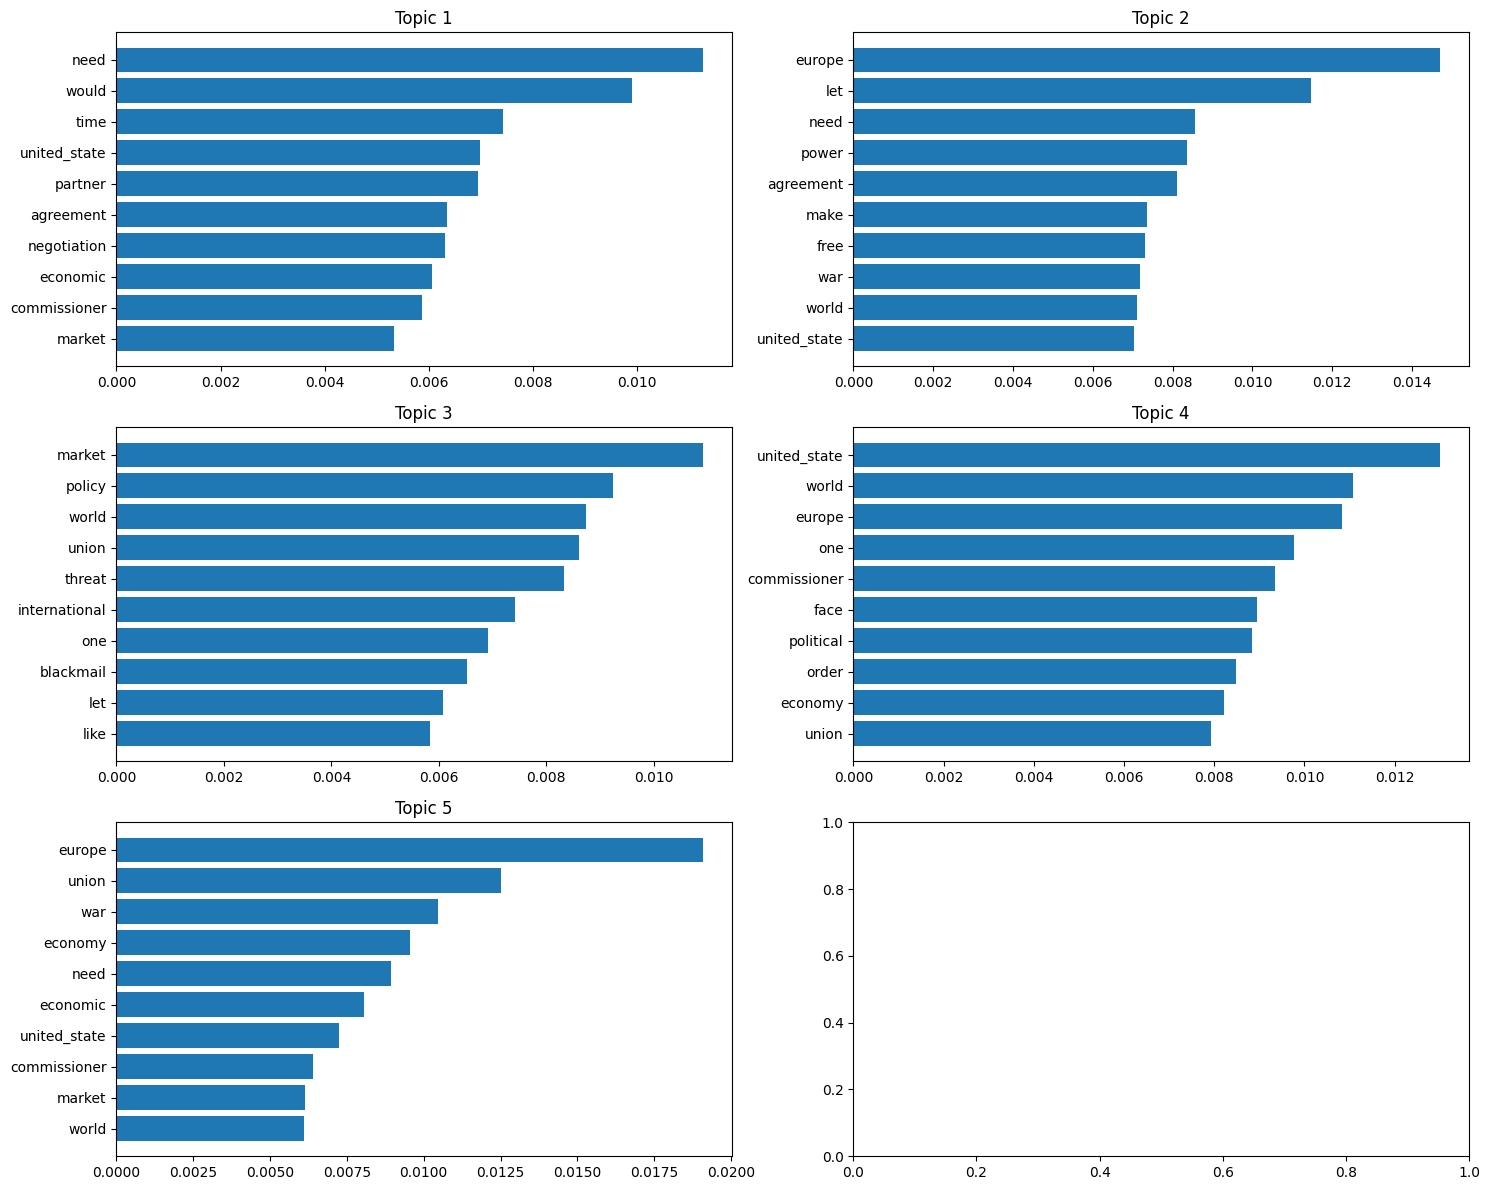


Model: chatgpt


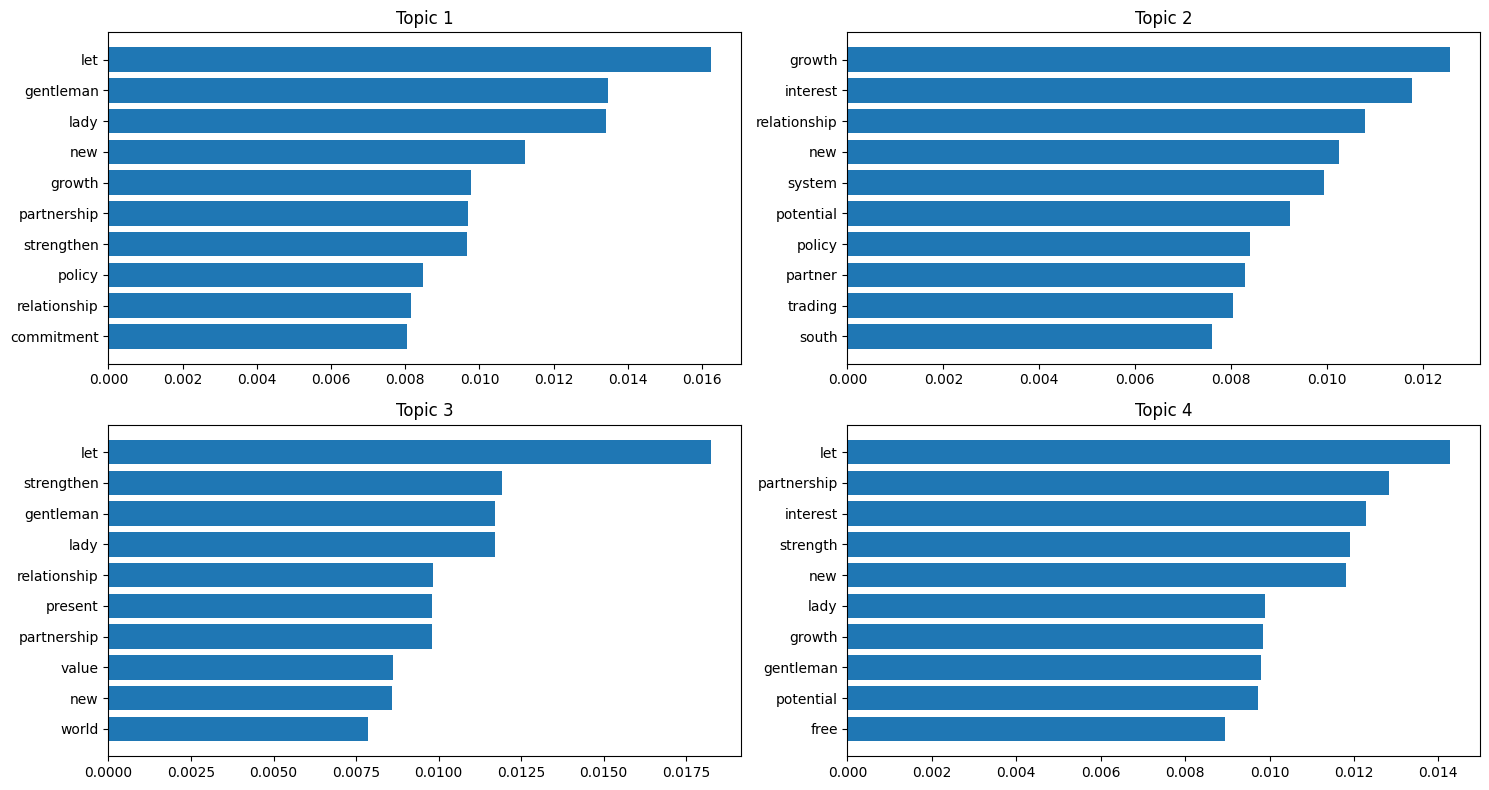


Model: deepseek


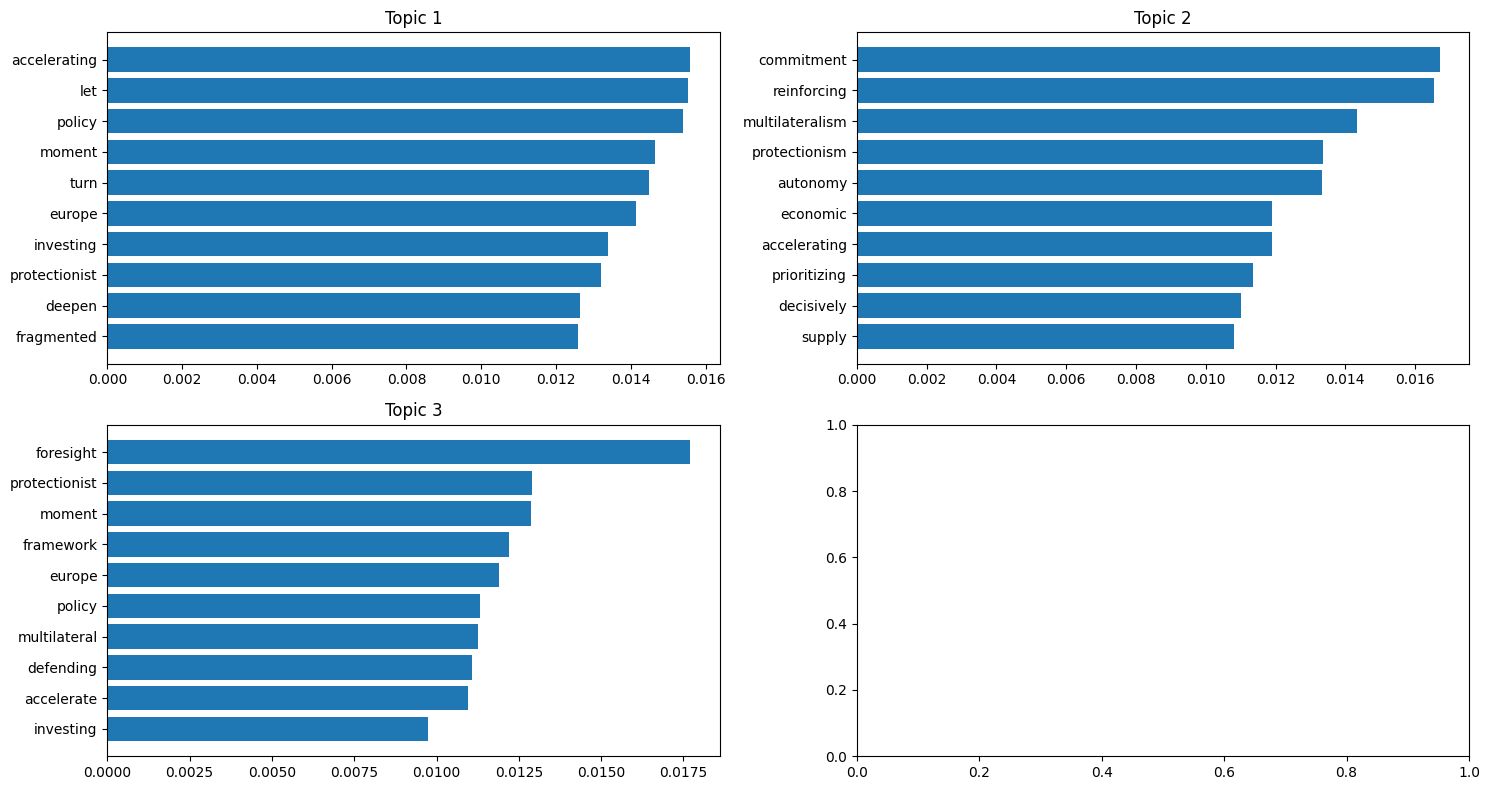

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_lda_topics(lda_model, dictionary, num_words=10):

    fig, axes = plt.subplots(int(np.ceil(lda_model.num_topics/2)), 2,
                            figsize=(15, 4*int(np.ceil(lda_model.num_topics/2))))
    axes = axes.flatten()

    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words, num_topics=-1):
        top_words = [w[0] for w in topic]
        top_probs = [w[1] for w in topic]

        axes[idx].barh(top_words, top_probs)
        axes[idx].set_title(f'Topic {idx+1}')
        axes[idx].invert_yaxis()

    plt.tight_layout()
    return fig

for name in names:
    print(f"\nModel: {name}")
    vis = visualize_lda_topics(models[name]['model'], models[name]['dict'], num_words=10)
    plt.show()